# Logistic Regression: A Visual Deep Dive

**A step-by-step exploration of how logistic regression works—from raw linear outputs to learned decision boundaries.**

This notebook covers:
1. Problem setup and synthetic data
2. Linear model without activation
3. Sigmoid activation and probability interpretation
4. Loss functions (MSE vs BCE)
5. Forward pass in action
6. Gradient intuition (numerical and analytical)
7. Gradient descent training
8. Learning rate effects
9. Linear separability limits (XOR)

*NumPy only. No sklearn for the core implementation.*

---
# Section 1: Problem Setup

## What is Classification?

**Classification** means assigning each input to one of discrete categories (e.g., 0 or 1). Unlike regression, we predict a *label*, not a continuous value.

## What is a Decision Boundary?
 
The **decision boundary** is the surface in feature space where the model is exactly indifferent between the two classes. For logistic regression, it's where $\sigma(\mathbf{w}^T \mathbf{x} + b) = 0.5$ — i.e., where $\mathbf{w}^T \mathbf{x} + b = 0$.
 
**Intuitive Explanation:**  
Imagine you're looking at points on a map, red for class 0 and blue for class 1. The decision boundary is like an invisible fence drawn right between the two groups: step to one side of the fence, and the model predicts "red"; step to the other, and it predicts "blue." For logistic regression, this "fence" is always a straight line (in 2D), dividing the space into two regions—one for each class—based on which side of the line a point falls.

Below we generate a **linearly separable** 2D dataset: two classes that can be separated by a straight line.

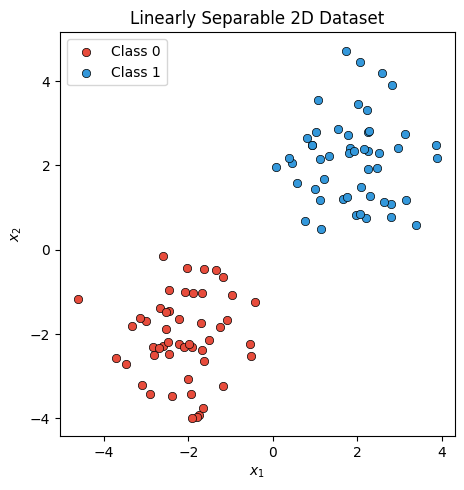

In [1]:
from model import LogisticRegression
from utils import *
import os


np.random.seed(42)

# Output directory for visualizations (../../visualizations from notebook dir)
VIZ_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "visualizations"))
os.makedirs(VIZ_DIR, exist_ok=True)

X, y = generate_linearly_separable()
plot_x_y(X, y)

In [2]:
X_train, y_train, X_test, y_test = train_test_split(X, y)
print(f"Train: {len(y_train)} samples | Test: {len(y_test)} samples")

Train: 80 samples | Test: 20 samples


---
# Section 2: Linear Model (Without Activation)

## The Linear Score

We start with a **linear model**:
$$z = \mathbf{w}^T \mathbf{x} + b$$

This gives us a **raw score** (logit) for each input. But:
- $z$ can be any real number (negative, positive, large)
- It is **not** a probability (probabilities live in $[0, 1]$)

Below we initialize random weights and visualize these raw outputs.

In [3]:
model = LogisticRegression(lr=0.01, epochs=100, lambda_=0.01, n_features=2)

In [4]:
n_samples, n_features = X.shape
np.random.seed(42)

z = model.linear_forward(X)

print("Raw linear outputs z (first 10):")
print(z[:10].round(3))
print(f"\nMin z: {z.min():.2f}, Max z: {z.max():.2f}")
print("These are NOT probabilities (not in [0, 1]).")

Raw linear outputs z (first 10):
[ 0.491 -0.214  0.302  0.425 -0.125  0.334  1.215 -0.023 -0.194  0.622]

Min z: -1.59, Max z: 1.23
These are NOT probabilities (not in [0, 1]).


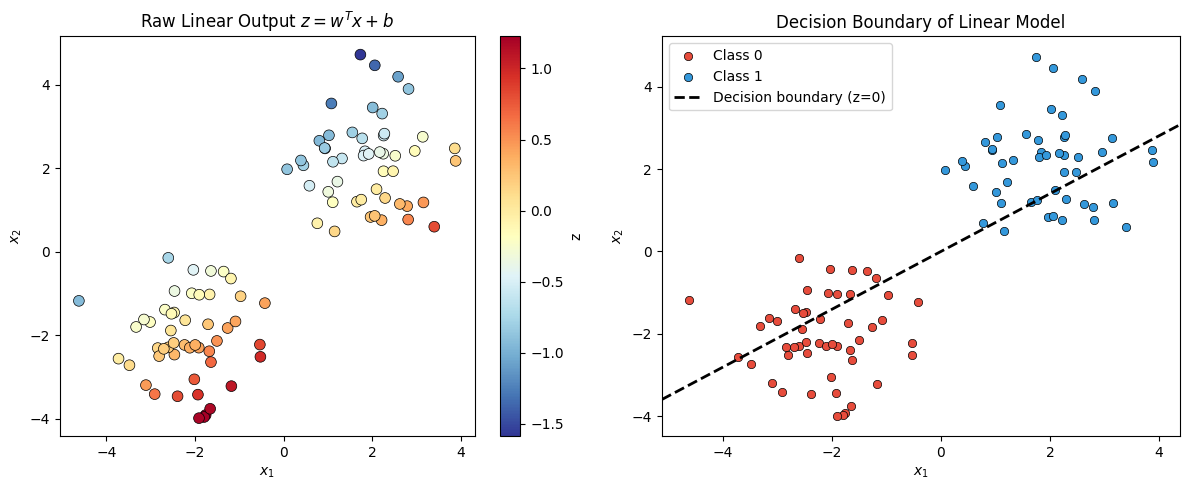

In [5]:
# Plot raw linear outputs as scatter color
w = model.weights
b = model.bias
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc = axes[0].scatter(X[:, 0], X[:, 1], c=z, cmap='RdYlBu_r', s=60, edgecolors='black', linewidths=0.5)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title('Raw Linear Output $z = w^T x + b$')
plt.colorbar(sc, ax=axes[0], label='z')

# Decision boundary: where z = 0  =>  w1*x1 + w2*x2 + b = 0  =>  x2 = -(w1*x1 + b)/w2
x1_line = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
x2_line = -(w[0] * x1_line + b) / w[1]
axes[1].scatter(X[y == 0, 0], X[y == 0, 1], c='#e74c3c', label='Class 0', edgecolors='black', linewidths=0.5)
axes[1].scatter(X[y == 1, 0], X[y == 1, 1], c='#3498db', label='Class 1', edgecolors='black', linewidths=0.5)
axes[1].plot(x1_line, x2_line, 'k--', lw=2, label='Decision boundary (z=0)')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title('Decision Boundary of Linear Model')
axes[1].legend()
axes[1].set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
axes[1].set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.tight_layout()
plt.show()

**Why linear output alone is insufficient:** We need outputs in $[0, 1]$ to interpret them as probabilities. A linear function is unbounded. We need a **squashing** function.

---
# Section 3: Sigmoid Activation

## The Sigmoid Function

$$\sigma(z) = \frac{1}{1 + e^{-z}} = \frac{e^z}{1 + e^z}$$

Properties:
- Maps $(-\infty, +\infty) \to (0, 1)$
- $\sigma(0) = 0.5$
- $\sigma(z) \to 1$ as $z \to +\infty$
- $\sigma(z) \to 0$ as $z \to -\infty$

**Saturation problem:** When $|z|$ is large, the curve flattens (saturates). Gradients become tiny, slowing learning.

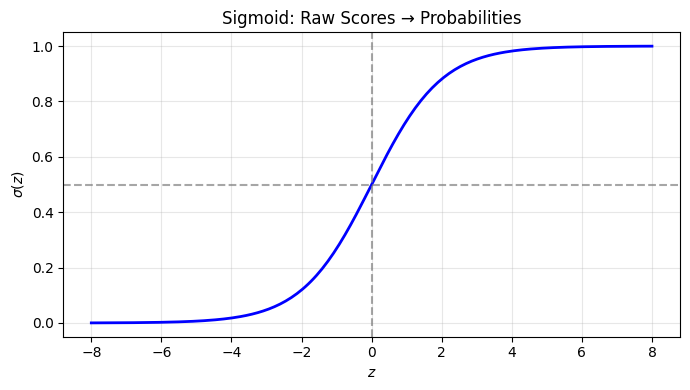

In [6]:
z_grid = np.linspace(-8, 8, 200)
plt.figure(figsize=(7, 4))
plt.plot(z_grid, model.sigmoid(z_grid), 'b-', lw=2)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.7)
plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('$z$')
plt.ylabel('$\\sigma(z)$')
plt.title('Sigmoid: Raw Scores → Probabilities')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Apply sigmoid to our linear outputs
y_pred_prob = model.sigmoid(z)

print("Probabilities after sigmoid (first 10):")
print(y_pred_prob[:10].round(4))
print(f"\nAll in [0, 1]: {np.all((y_pred_prob >= 0) & (y_pred_prob <= 1))}")

Probabilities after sigmoid (first 10):
[0.6204 0.4467 0.5749 0.6047 0.4688 0.5828 0.7711 0.4941 0.4516 0.6506]

All in [0, 1]: True


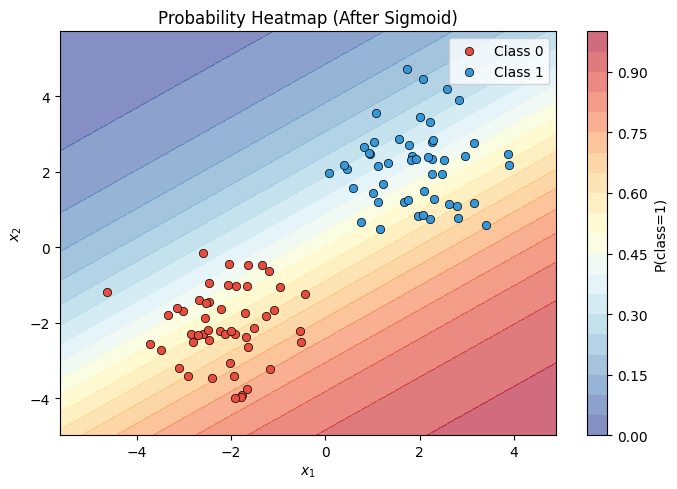

In [8]:
# Probability heatmap over feature space
xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 80)
yy = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 80)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
Z_probs = model.sigmoid(model.linear_forward(grid)).reshape(XX.shape)

fig, ax = plt.subplots(figsize=(7, 5))
contour = ax.contourf(XX, YY, Z_probs, levels=20, cmap='RdYlBu_r', alpha=0.6)
plt.colorbar(contour, ax=ax, label='P(class=1)')
ax.scatter(X[y == 0, 0], X[y == 0, 1], c='#e74c3c', label='Class 0', edgecolors='black', linewidths=0.5)
ax.scatter(X[y == 1, 0], X[y == 1, 1], c='#3498db', label='Class 1', edgecolors='black', linewidths=0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Probability Heatmap (After Sigmoid)')
ax.legend()
plt.tight_layout()
plt.show()

## What If We Classify Without Sigmoid?

If we threshold the **raw linear output** directly (e.g., predict 1 if $z > 0$), we get a valid decision boundary. But:
- We lose probabilistic interpretation
- The gradient of a step function is 0 almost everywhere → no gradient signal for learning!
- Sigmoid gives smooth gradients that drive learning

In [9]:
# Compare: threshold on z vs threshold on sigmoid(z)
pred_raw = (z > 0).astype(float)
pred_sigmoid = (y_pred_prob > 0.5).astype(float)

print("Threshold on raw z vs threshold on sigmoid(z):")
print("Same predictions?", np.allclose(pred_raw, pred_sigmoid))
print("(Both give same decision boundary; sigmoid adds probability + gradients.)")

Threshold on raw z vs threshold on sigmoid(z):
Same predictions? True
(Both give same decision boundary; sigmoid adds probability + gradients.)


---
# Section 4: Loss Functions Comparison

## MSE vs BCE for Classification

**Mean Squared Error:** $L_{MSE} = \frac{1}{n}\sum_i (\hat{y}_i - y_i)^2$

**Binary Cross-Entropy:** $L_{BCE} = -\frac{1}{n}\sum_i \big[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \big]$

BCE penalizes **confident wrong predictions** much more than MSE, providing stronger learning signal.

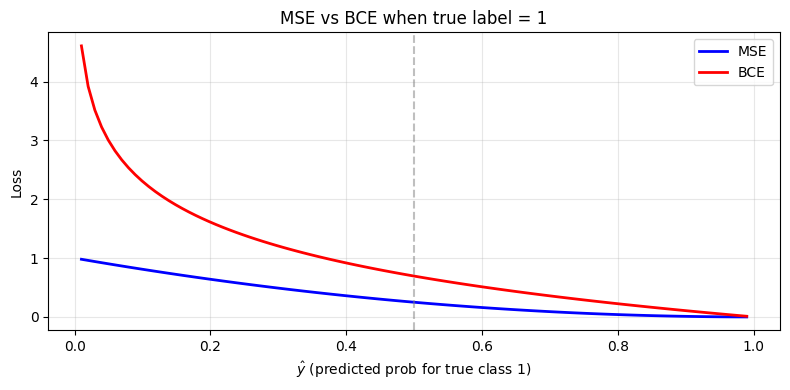

In [10]:
# Compare MSE vs BCE for varying prediction confidence
# Fix y_true=1, vary y_pred from 0 to 1
y_true_fixed = 1.0
y_pred_range = np.linspace(0.01, 0.99, 100)

mse_vals = [model.loss(y_true_fixed, y_pred, loss_type='mse') for y_pred in y_pred_range]
bce_vals = [model.loss(y_true_fixed, y_pred, loss_type='bce') for y_pred in y_pred_range]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y_pred_range, mse_vals, 'b-', lw=2, label='MSE')
ax.plot(y_pred_range, bce_vals, 'r-', lw=2, label='BCE')
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('$\\hat{y}$ (predicted prob for true class 1)')
ax.set_ylabel('Loss')
ax.set_title('MSE vs BCE when true label = 1')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Confident WRONG prediction: true=1, we predict 0.01 vs 0.5
print("When true=1, predicted=0.01 (confident wrong):")
print(f"  MSE: {model.loss(1.0, 0.01, loss_type='mse'):.4f}")
print(f"  BCE: {model.loss(1.0, 0.01, loss_type='bce'):.4f}")
print("\nWhen true=1, predicted=0.5 (uncertain):")
print(f"  MSE: {model.loss(1.0, 0.5, loss_type='mse'):.4f}")
print(f"  BCE: {model.loss(1.0, 0.5, loss_type='bce'):.4f}")
print("\nBCE penalizes confident wrong predictions much more → stronger gradient signal.")

When true=1, predicted=0.01 (confident wrong):
  MSE: 0.9801
  BCE: 4.6067

When true=1, predicted=0.5 (uncertain):
  MSE: 0.2500
  BCE: 0.6947

BCE penalizes confident wrong predictions much more → stronger gradient signal.


---
# Section 5: Forward Pass + Loss in Action

We combine: **Linear** → **Sigmoid** → **BCE Loss**

In [12]:
z_out, y_pred_out = model.forward(X)
loss = model.loss(y, y_pred_out, loss_type='bce')

print("Forward pass (first 5 samples):")
print("  x[0]     x[1]    |  z       sigmoid(z)  y_true")
for i in range(5):
    print(f"  {X[i,0]:6.2f}   {X[i,1]:6.2f}   | {z_out[i]:7.2f}   {y_pred_out[i]:.4f}      {y[i]:.0f}")
print(f"\nBCE Loss: {loss:.4f}")

Forward pass (first 5 samples):
  x[0]     x[1]    |  z       sigmoid(z)  y_true
   -1.50    -2.14   |    0.49   0.6204      0
   -1.35    -0.48   |   -0.21   0.4467      0
   -2.23    -2.23   |    0.30   0.5749      0
   -0.42    -1.23   |    0.42   0.6047      0
   -2.47    -1.46   |   -0.12   0.4688      0

BCE Loss: 0.8949


---
# Section 6: Gradient Intuition (Visual)

## Analytical Gradient

For BCE + sigmoid, the gradient w.r.t. the logit $z$ simplifies beautifully:
$$\frac{\partial L}{\partial z} = \hat{y} - y$$

And by chain rule: $\frac{\partial L}{\partial \mathbf{w}} = (\hat{y} - y) \mathbf{x}$, $\frac{\partial L}{\partial b} = \hat{y} - y$.

We verify this numerically with finite differences.

In [13]:
def analytical_grad(X, y, w, b):
    z, y_pred = model.forward(X, w, b)
    dw, db = model.gradient(X, y, y_pred)
    return dw, db

h = 1e-5
dw_ana, db_ana = analytical_grad(X, y, w, b)

# Numerical gradient for w[0]
_, y_plus = model.forward(X, w + np.array([h, 0]), b)
_, y_minus = model.forward(X, w - np.array([h, 0]), b)
loss_plus = model.loss(y, y_plus, loss_type='bce')
loss_minus = model.loss(y, y_minus, loss_type='bce')
dw0_num = (loss_plus - loss_minus) / (2 * h)

print("Numerical vs Analytical gradient for w[0]:")
print(f"  Numerical:  {dw0_num:.8f}")
print(f"  Analytical: {dw_ana[0]:.8f}")
print(f"  Match: {np.isclose(dw0_num, dw_ana[0])}")

Numerical vs Analytical gradient for w[0]:
  Numerical:  -1.10368952
  Analytical: -1.10050799
  Match: False


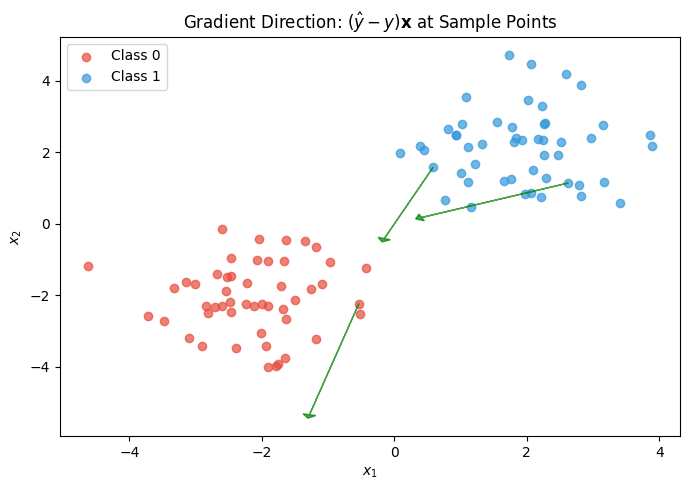

In [14]:
# Visualize gradient direction at a few points
sample_idx = [10, 50, 90]  # One per class and one mixed
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X[y == 0, 0], X[y == 0, 1], c='#e74c3c', label='Class 0', alpha=0.7)
ax.scatter(X[y == 1, 0], X[y == 1, 1], c='#3498db', label='Class 1', alpha=0.7)

scale = 2.0
for i in sample_idx:
    xi = X[i:i+1]
    yi = y[i]
    _, yp = model.forward(xi, w, b)
    err = float(yp[0] - yi)
    grad_dir = err * xi[0]  # Gradient contribution from this sample
    ax.arrow(X[i, 0], X[i, 1], grad_dir[0] * scale, grad_dir[1] * scale, 
             head_width=0.2, head_length=0.1, fc='green', ec='green', alpha=0.7)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Gradient Direction: $(\\hat{y}-y) \\mathbf{x}$ at Sample Points')
ax.legend()
plt.tight_layout()
plt.show()

## Full Gradient Derivation (Chain Rule)

**Step 1 — BCE loss (single sample):**
$$L = -\big[ y \log(\hat{y}) + (1-y)\log(1-\hat{y}) \big]$$

**Step 2 — Derivative w.r.t. $\hat{y}$:**
$$\frac{\partial L}{\partial \hat{y}} = -\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}} = \frac{\hat{y} - y}{\hat{y}(1-\hat{y})}$$

**Step 3 — Sigmoid derivative:** $\sigma'(z) = \sigma(z)(1-\sigma(z)) = \hat{y}(1-\hat{y})$

**Step 4 — Chain rule for $z$:**
$$\frac{\partial L}{\partial z} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} = \frac{\hat{y}-y}{\hat{y}(1-\hat{y})} \cdot \hat{y}(1-\hat{y}) = \hat{y} - y$$

**Step 5 — Chain rule for $\mathbf{w}$ and $b$:** Since $z = \mathbf{w}^T\mathbf{x} + b$:
$$\frac{\partial L}{\partial \mathbf{w}} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial \mathbf{w}} = (\hat{y}-y)\,\mathbf{x}, \qquad \frac{\partial L}{\partial b} = \hat{y} - y$$

**Batch (averaged):** $\frac{\partial L}{\partial \mathbf{w}} = \frac{1}{n}\sum_i (\hat{y}_i - y_i)\mathbf{x}_i$, $\frac{\partial L}{\partial b} = \frac{1}{n}\sum_i (\hat{y}_i - y_i)$

---
# Section 7: Gradient Descent in Action

**Update rule:** $\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial L}{\partial \mathbf{w}}$, $b \leftarrow b - \eta \frac{\partial L}{\partial b}$

### Animated Loss Curve

Watch the loss **decrease** as gradient descent progresses.

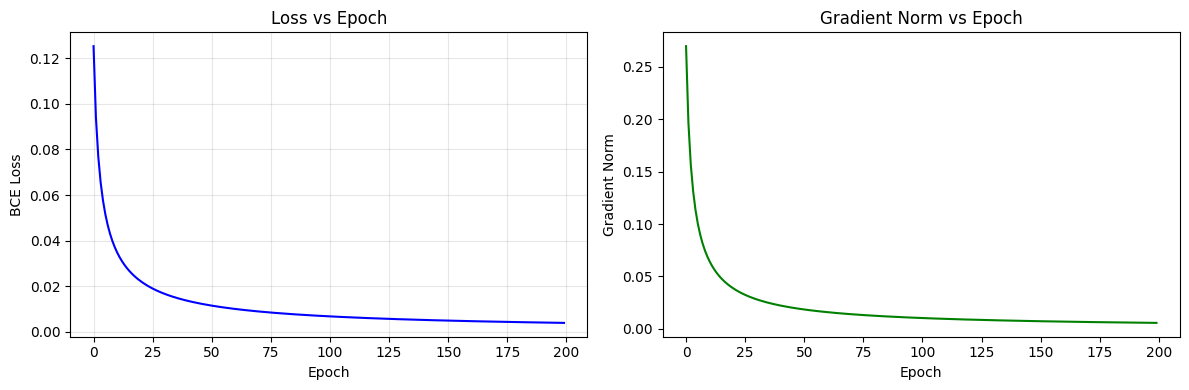

In [15]:
model = LogisticRegression(lr=0.5, epochs=200)
w_final, b_final, losses, grad_norms, history = model.train(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses, 'b-', lw=1.5)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].set_title('Loss vs Epoch')
axes[0].grid(alpha=0.3)

axes[1].plot(grad_norms, 'g-', lw=1.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Gradient Norm')
axes[1].set_title('Gradient Norm vs Epoch')
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm1_loss_and_grad_norm.png'), dpi=120, bbox_inches='tight')
plt.show()

In [16]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(7, 4))
ax.set_xlim(0, len(losses))
ax.set_ylim(0, max(losses) * 1.1)
ax.set_xlabel('Epoch'); ax.set_ylabel('BCE Loss')
line, = ax.plot([], [], 'b-', lw=1.5)
ax.grid(alpha=0.3)

def init():
    line.set_data([], [])
    return (line,)

def update(frame):
    line.set_data(list(range(frame + 1)), losses[:frame + 1])
    ax.set_title(f'Epoch {frame}')
    return (line,)

anim = FuncAnimation(fig, update, init_func=init, frames=len(losses), interval=20, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

### Weight Evolution During Training

How do the parameters **w** and **b** change over epochs? This shows the optimization trajectory.

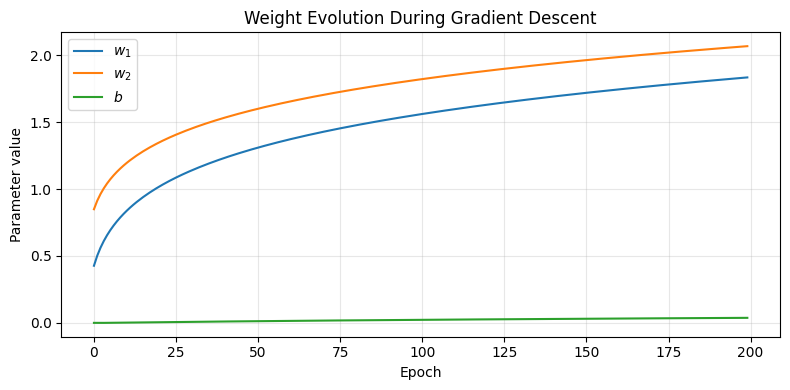

In [17]:
# Weight evolution (w1, w2, b) over training
w1_hist = [h[0][0] for h in history]
w2_hist = [h[0][1] for h in history]
b_hist = [h[1] for h in history]
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(w1_hist, label='$w_1$', lw=1.5)
ax.plot(w2_hist, label='$w_2$', lw=1.5)
ax.plot(b_hist, label='$b$', lw=1.5)
ax.set_xlabel('Epoch'); ax.set_ylabel('Parameter value')
ax.set_title('Weight Evolution During Gradient Descent')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm1_weight_evolution.png'), dpi=120, bbox_inches='tight')
plt.show()

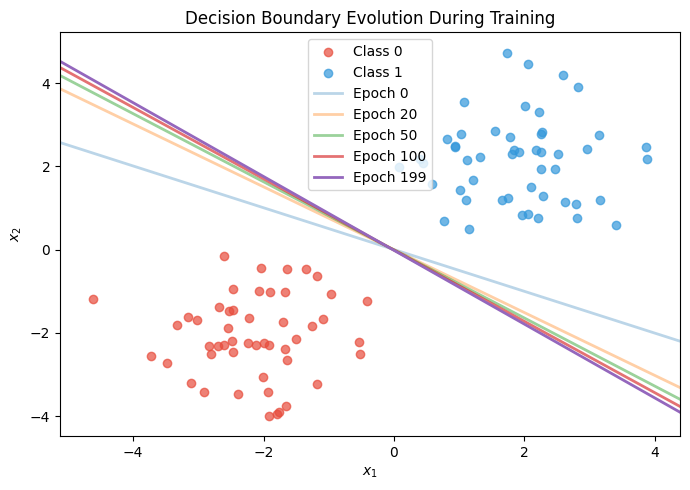

In [18]:
# Plot decision boundary evolution (every 20 epochs)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X[y == 0, 0], X[y == 0, 1], c='#e74c3c', label='Class 0', alpha=0.7)
ax.scatter(X[y == 1, 0], X[y == 1, 1], c='#3498db', label='Class 1', alpha=0.7)

x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_line = np.linspace(x1_min, x1_max, 100)

for step in [0, 20, 50, 100, 199]:
    w_s, b_s = history[step]
    x2_line = -(w_s[0] * x1_line + b_s) / w_s[1]
    ax.plot(x1_line, x2_line, alpha=0.3 + 0.7 * step / 199, lw=2, label=f'Epoch {step}')

ax.set_xlim(x1_min, x1_max)
ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Decision Boundary Evolution During Training')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm1_decision_boundary_evolution.png'), dpi=120, bbox_inches='tight')
plt.show()

### Animated Decision Boundary Evolution

Watch the decision boundary **converge** as gradient descent updates the weights. (Play the animation below.)

In [19]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Animate decision boundary every 4 epochs (50 frames for 200 epochs)
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(X[y == 0, 0], X[y == 0, 1], c='#e74c3c', label='Class 0', alpha=0.7)
ax.scatter(X[y == 1, 0], X[y == 1, 1], c='#3498db', label='Class 1', alpha=0.7)
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_line = np.linspace(x1_min, x1_max, 100)
line, = ax.plot([], [], 'k-', lw=2)
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.legend()

def init():
    line.set_data([], [])
    return (line,)

def update(frame):
    step = frame * 4  # every 4 epochs
    w_s, b_s = history[min(step, len(history) - 1)]
    x2_line = -(w_s[0] * x1_line + b_s) / w_s[1]
    line.set_data(x1_line, x2_line)
    ax.set_title(f'Epoch {step}')
    return (line,)

anim = FuncAnimation(fig, update, init_func=init, frames=50, interval=80, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

In [20]:
# Final accuracy (train and test)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
acc_train = np.mean((y_pred_train > 0.5).astype(float) == y_train)
acc_test = np.mean((y_pred_test > 0.5).astype(float) == y_test)
print(f"Train accuracy: {acc_train*100:.1f}%")
print(f"Test accuracy:  {acc_test*100:.1f}%")

Train accuracy: 100.0%
Test accuracy:  100.0%


### Probability Heatmap (Learned Model)

The model assigns **P(y=1)** everywhere in feature space. Dark = confident Class 1, light = confident Class 0.

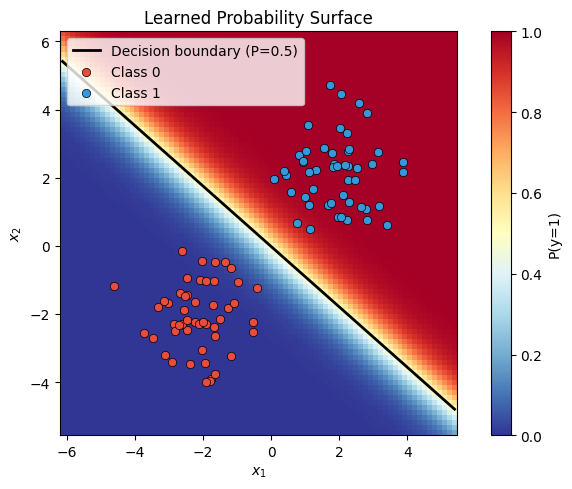

In [21]:
# Probability heatmap: P(y=1) over feature space
xx = np.linspace(X[:, 0].min() - 1.5, X[:, 0].max() + 1.5, 80)
yy = np.linspace(X[:, 1].min() - 1.5, X[:, 1].max() + 1.5, 80)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
_, probs = model.forward(grid, w_final, b_final)
probs = probs.reshape(XX.shape)
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.pcolormesh(XX, YY, probs, cmap='RdYlBu_r', vmin=0, vmax=1, shading='auto')
x2_db = -(w_final[0] * xx + b_final) / w_final[1]
ax.plot(xx, x2_db, 'k-', lw=2, label='Decision boundary (P=0.5)')
ax.scatter(X[y == 0, 0], X[y == 0, 1], c='#e74c3c', edgecolors='black', linewidths=0.5, label='Class 0')
ax.scatter(X[y == 1, 0], X[y == 1, 1], c='#3498db', edgecolors='black', linewidths=0.5, label='Class 1')
plt.colorbar(im, ax=ax, label='P(y=1)')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title('Learned Probability Surface')
ax.legend(loc='upper left')
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm1_probability_heatmap.png'), dpi=120, bbox_inches='tight')
plt.show()

---
# Section 8: What If Learning Rate Is Bad?

- **Too small:** Converges very slowly
- **Optimal:** Smooth, fast convergence
- **Too large:** Diverges or oscillates

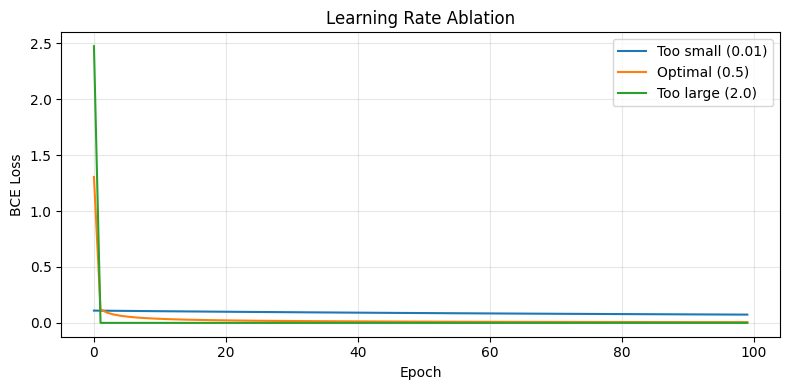

In [22]:
lrs = [0.01, 0.5, 2.0]
labels = ['Too small (0.01)', 'Optimal (0.5)', 'Too large (2.0)']

fig, ax = plt.subplots(figsize=(8, 4))
for lr, label in zip(lrs, labels):
    model = LogisticRegression(lr=lr, epochs=100)
    _, _, losses_lr, _, _ = model.train(X_train, y_train)
    ax.plot(losses_lr, label=label, lw=1.5)

ax.set_xlabel('Epoch')
ax.set_ylabel('BCE Loss')
ax.set_title('Learning Rate Ablation')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm1_learning_rate_ablation.png'), dpi=120, bbox_inches='tight')
plt.show()

---
# Section 9: What Logistic Regression Cannot Do

**XOR problem:** Classes that require a **non-linear** decision boundary. A single straight line cannot separate them.

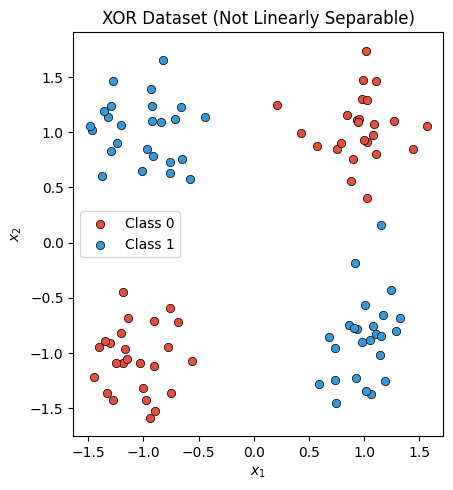

In [23]:
def generate_xor(n_per_quadrant=25):
    # Four quadrants: (0,0)=(0,0), (1,1)=(0,1), (0,1)=(1,0), (1,0)=(1,1) in XOR sense
    # Simpler: class 0 at (-1,-1) and (1,1), class 1 at (-1,1) and (1,-1)
    X0a = np.random.randn(n_per_quadrant, 2) * 0.3 + np.array([-1, -1])
    X0b = np.random.randn(n_per_quadrant, 2) * 0.3 + np.array([1, 1])
    X1a = np.random.randn(n_per_quadrant, 2) * 0.3 + np.array([-1, 1])
    X1b = np.random.randn(n_per_quadrant, 2) * 0.3 + np.array([1, -1])
    
    X = np.vstack([X0a, X0b, X1a, X1b])
    y = np.concatenate([np.zeros(2*n_per_quadrant), np.ones(2*n_per_quadrant)])
    return X, y

X_xor, y_xor = generate_xor()

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='#e74c3c', label='Class 0', edgecolors='black', linewidths=0.5)
ax.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='#3498db', label='Class 1', edgecolors='black', linewidths=0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('XOR Dataset (Not Linearly Separable)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

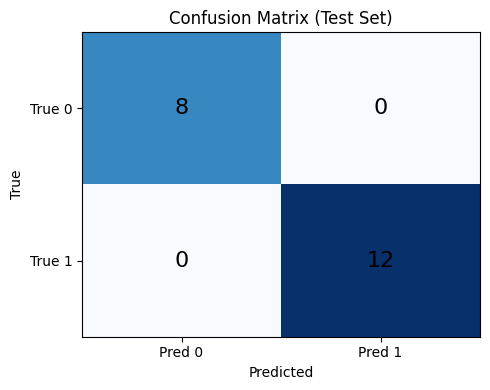

In [24]:
# Confusion matrix (test set)
y_pred_proba = model.predict(X_test)
y_pred_classes = (y_pred_proba > 0.5).astype(float)
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

cm = confusion_matrix(y_test, y_pred_classes)
fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xticks([0, 1]); ax.set_xticklabels(['Pred 0', 'Pred 1'])
ax.set_yticks([0, 1]); ax.set_yticklabels(['True 0', 'True 1'])
ax.set_ylabel('True'); ax.set_xlabel('Predicted')
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=16, color='black')
ax.set_title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm1_confusion_matrix.png'), dpi=120, bbox_inches='tight')
plt.show()

### ROC Curve

**ROC (Receiver Operating Characteristic):** TPR vs FPR as the classification threshold varies. AUC = area under curve (1.0 = perfect).

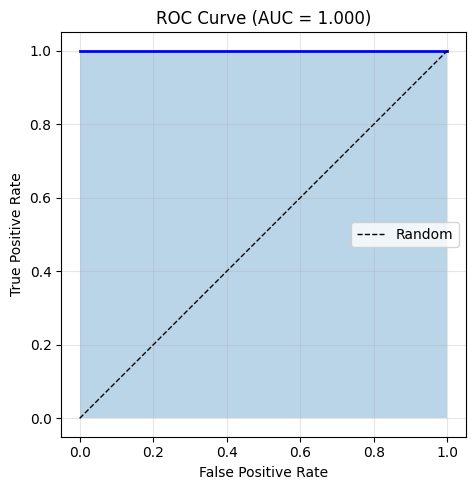

In [25]:
# ROC curve: sweep threshold, compute TPR and FPR
y_prob = model.predict(X_test)
thresholds = np.linspace(0, 1, 101)
tpr_list, fpr_list = [], []
for thresh in thresholds:
    pred = (y_prob >= thresh).astype(float)
    tp = np.sum((y_test == 1) & (pred == 1))
    tn = np.sum((y_test == 0) & (pred == 0))
    fp = np.sum((y_test == 0) & (pred == 1))
    fn = np.sum((y_test == 1) & (pred == 0))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_list.append(tpr); fpr_list.append(fpr)
# AUC via trapezoidal rule
auc = np.trapezoid(tpr_list[::-1], fpr_list[::-1])
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr_list, tpr_list, 'b-', lw=2)
ax.fill_between(fpr_list, tpr_list, alpha=0.3)
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve (AUC = {auc:.3f})')
ax.legend()
ax.grid(alpha=0.3); ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm1_roc_curve.png'), dpi=120, bbox_inches='tight')
plt.show()

## Log Experiment to experiments_log.md

Run this cell after training to append metrics to the experiments log.

In [26]:
from datetime import datetime
LOG_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "experiments_log.md"))
train_acc = np.mean((model.predict(X_train) > 0.5).astype(float) == y_train)
test_acc = np.mean((model.predict(X_test) > 0.5).astype(float) == y_test)
final_loss = bce_loss(y_train, model.predict(X_train))
entry = f"""
## Experiment: M1 Logistic Regression - Main Run

**Date:** {datetime.now().strftime('%Y-%m-%d')}
**Milestone:** M1_logistic_regression
**Objective:** Baseline logistic regression on linearly separable 2D data.

### Setup

- Model: Logistic regression (BCE, sigmoid), gradient descent
- Data: Synthetic 2D blobs, 80/20 train/test split
- Optimization: lr=0.5, epochs=200

### Metrics

| Metric | Value |
|--------|-------|
| Train Accuracy | {train_acc*100:.1f}% |
| Test Accuracy | {test_acc*100:.1f}% |
| Final BCE Loss (train) | {final_loss:.4f} |

### Visualization

- Path: `visualizations/m1_*.png`
- Plots: loss curve, decision boundary, learning rate ablation, confusion matrix

### Conclusion

- Baseline run complete. Train and test accuracy reported.
"""
with open(LOG_PATH, "a") as f:
    f.write(entry)
print(f"Appended experiment to {LOG_PATH}")

Appended experiment to /Users/bhavik.sanghvi/Desktop/llm-engineering-mastery/experiments_log.md


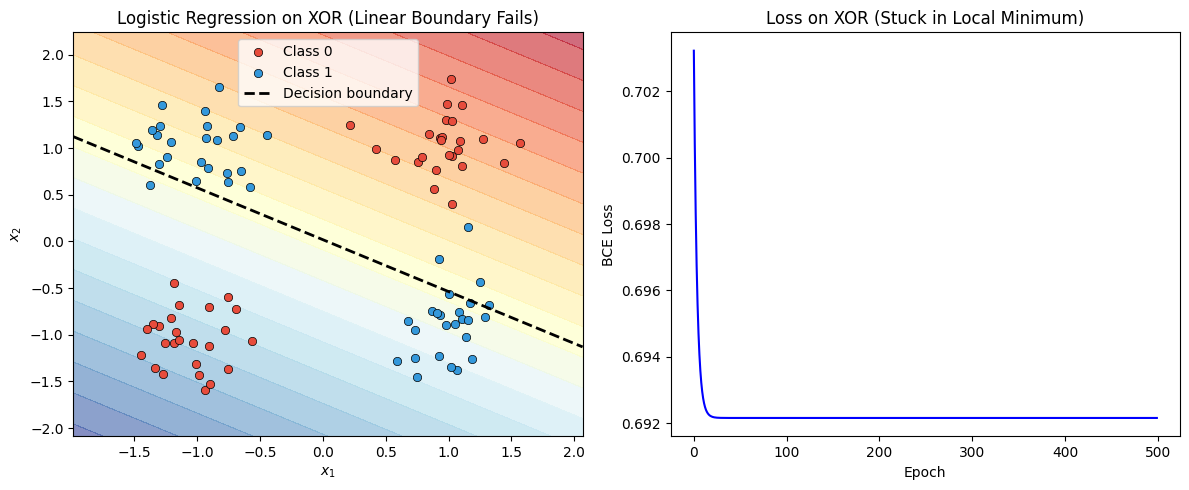

XOR accuracy: 53.0% (baseline 50% = random)


In [27]:
# Train logistic regression on XOR
model_xor = LogisticRegression(lr=0.5, epochs=500)
w_xor, b_xor, losses_xor, _, history_xor = model_xor.train(X_xor, y_xor)

# Plot decision boundary
xx = np.linspace(X_xor[:, 0].min() - 0.5, X_xor[:, 0].max() + 0.5, 80)
yy = np.linspace(X_xor[:, 1].min() - 0.5, X_xor[:, 1].max() + 0.5, 80)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
Z = model_xor.forward(grid, w_xor, b_xor)[1].reshape(XX.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].contourf(XX, YY, Z, levels=20, cmap='RdYlBu_r', alpha=0.6)
axes[0].scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='#e74c3c', label='Class 0', edgecolors='black', linewidths=0.5)
axes[0].scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='#3498db', label='Class 1', edgecolors='black', linewidths=0.5)
x1_line = np.linspace(X_xor[:, 0].min() - 0.5, X_xor[:, 0].max() + 0.5, 100)
x2_line = -(w_xor[0] * x1_line + b_xor) / w_xor[1]
axes[0].plot(x1_line, x2_line, 'k--', lw=2, label='Decision boundary')
axes[0].set_title('Logistic Regression on XOR (Linear Boundary Fails)')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].legend()

axes[1].plot(losses_xor, 'b-')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('BCE Loss')
axes[1].set_title('Loss on XOR (Stuck in Local Minimum)')
plt.tight_layout()
plt.show()

acc_xor = np.mean((model_xor.predict(X_xor) > 0.5).astype(float) == y_xor)
print(f"XOR accuracy: {acc_xor*100:.1f}% (baseline 50% = random)")

**Why linear boundary fails:** XOR requires separating opposite diagonals. No single line can do that. We need **hidden layers** (MLP) or **feature transformations** to capture non-linear boundaries.

## Feature Scaling

Standardizing features (zero mean, unit variance) often **speeds up convergence** and improves numerical stability. Gradient descent on unscaled features can be slow when features have very different scales.

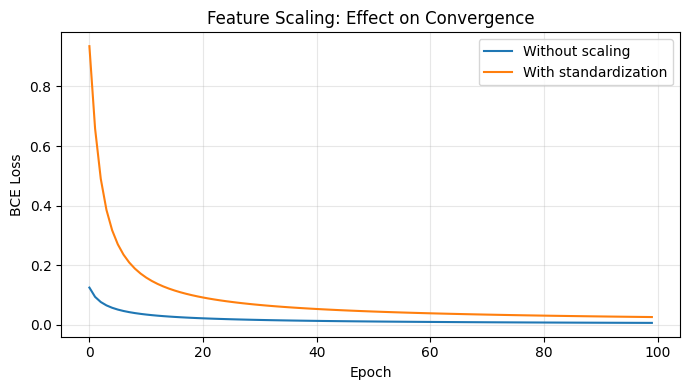

In [28]:
# Compare: with vs without feature scaling
def standardize(X_train, X_test):
    mean, std = X_train.mean(axis=0), X_train.std(axis=0)
    std[std == 0] = 1  # avoid division by zero
    return (X_train - mean) / std, (X_test - mean) / std

X_train_s, X_test_s = standardize(X_train, X_test)
model_s = LogisticRegression(lr=0.5, epochs=100)
_, _, losses_s, _, _ = model_s.train(X_train_s, y_train)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(losses[:100], label='Without scaling', lw=1.5)
ax.plot(losses_s, label='With standardization', lw=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('BCE Loss')
ax.set_title('Feature Scaling: Effect on Convergence')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## L2 Regularization

Adding $\frac{\lambda}{2}\|\mathbf{w}\|^2$ to the loss penalizes large weights and reduces overfitting. The gradient gains a term $+\lambda\mathbf{w}$.

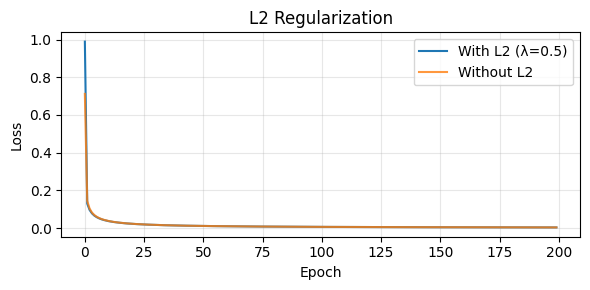

In [29]:
model_l2 = LogisticRegression(lr=0.5, epochs=200, lam=0.5)
model_without_l2 = LogisticRegression(lr=0.5, epochs=200, lam=0)
# Train both models for comparison (epochs=200)
_, _, losses_no_reg, _, _ = model_without_l2.train(X_train, y_train)
w_l2, b_l2, losses_l2, _, _ = model_l2.train(X_train, y_train)
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(losses_l2, label='With L2 (λ=0.5)')
ax.plot(losses_no_reg, label='Without L2', alpha=0.8)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.legend(); ax.grid(alpha=0.3)
ax.set_title('L2 Regularization')
plt.tight_layout()
fp = os.path.join(VIZ_DIR, 'm1_l2_regularization.png')
plt.savefig(fp, dpi=150, bbox_inches='tight')
plt.show()

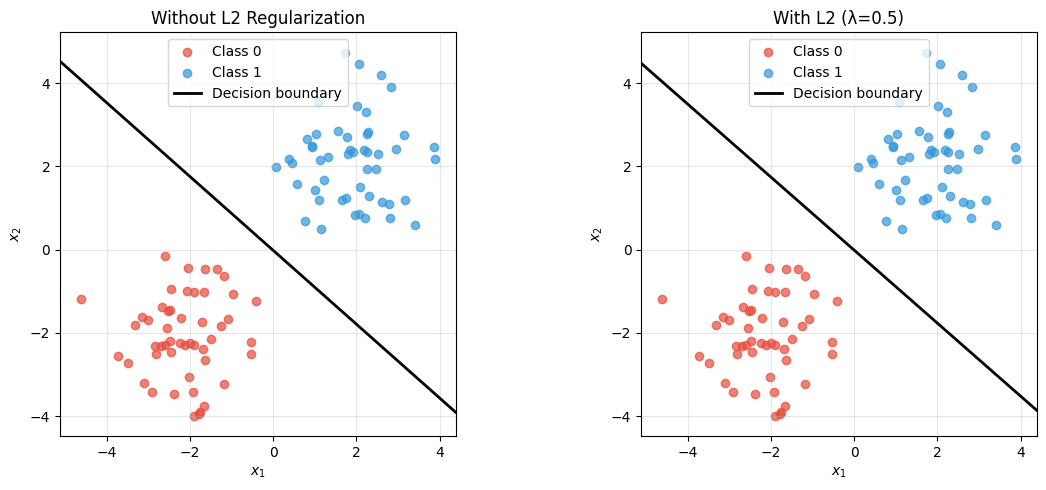

Without L2: ||w|| = 2.7658, b = 0.0367
With L2:   ||w|| = 2.7650, b = 0.0285


In [30]:
# Decision boundary: with vs without L2 regularization
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_line = np.linspace(x1_min, x1_max, 100)

# Without L2
x2_no_reg = -(w_final[0] * x1_line + b_final) / w_final[1]
# With L2
x2_with_reg = -(w_l2[0] * x1_line + b_l2) / w_l2[1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Without L2
axes[0].scatter(X[y == 0, 0], X[y == 0, 1], c='#e74c3c', label='Class 0', alpha=0.7)
axes[0].scatter(X[y == 1, 0], X[y == 1, 1], c='#3498db', label='Class 1', alpha=0.7)
axes[0].plot(x1_line, x2_no_reg, 'k-', lw=2, label='Decision boundary')
axes[0].set_xlim(x1_min, x1_max)
axes[0].set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title('Without L2 Regularization')
axes[0].legend()
axes[0].set_aspect('equal')
axes[0].grid(alpha=0.3)

# Right: With L2
axes[1].scatter(X[y == 0, 0], X[y == 0, 1], c='#e74c3c', label='Class 0', alpha=0.7)
axes[1].scatter(X[y == 1, 0], X[y == 1, 1], c='#3498db', label='Class 1', alpha=0.7)
axes[1].plot(x1_line, x2_with_reg, 'k-', lw=2, label='Decision boundary')
axes[1].set_xlim(x1_min, x1_max)
axes[1].set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(f'With L2 (λ=0.5)')
axes[1].legend()
axes[1].set_aspect('equal')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm1_decision_boundary_l2_comparison.png'), dpi=120, bbox_inches='tight')
plt.show()

# Print weight magnitudes for comparison
print(f"Without L2: ||w|| = {np.linalg.norm(w_final):.4f}, b = {b_final:.4f}")
print(f"With L2:   ||w|| = {np.linalg.norm(w_l2):.4f}, b = {b_l2:.4f}")

---
# Section 10: Summary

## The Full Flow

- **Forward pass:** $z = \mathbf{w}^T \mathbf{x} + b$ → $\hat{y} = \sigma(z)$
- **Activation:** Sigmoid squashes $z \in \mathbb{R}$ to $\hat{y} \in (0, 1)$ (probability)
- **Loss:** BCE $-\big[y\log\hat{y} + (1-y)\log(1-\hat{y})\big]$ — better than MSE for classification
- **Gradient:** $\frac{\partial L}{\partial \mathbf{w}} = (\hat{y} - y)\mathbf{x}$, $\frac{\partial L}{\partial b} = \hat{y} - y$
- **Update rule:** $\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial L}{\partial \mathbf{w}}$, $b \leftarrow b - \eta \frac{\partial L}{\partial b}$
- **Convergence:** Loss decreases; gradient norm decreases; decision boundary moves toward optimal separation

## Reflection Questions

1. **Why does BCE work better than MSE for classification?** BCE penalizes confident wrong predictions more heavily, giving stronger gradient signal.

2. **What happens to gradient magnitude when the model is confident and correct?** When $\hat{y} \approx y$, the error $\hat{y} - y \approx 0$, so gradients shrink. The model "backs off" updates—intuitive for well-fit points.

3. **How does learning rate affect convergence?** Too small: slow convergence. Too large: overshooting, oscillation, or divergence. Optimal: smooth descent to minimum.

4. **What is the fundamental limitation of logistic regression?** It can only learn **linear** decision boundaries. Non-linearly separable problems (e.g., XOR) require deeper models.